# RF simulation

In this tutorial we will look into the RF simulator of FEMWELL. 

<div style="text-align: center;">
  <img src="support/main.png" alt="Alt text" style="max-width: 80%; height: auto;">
</div>

To illustrate how to do this, we will use a new `CPW` class where we explore a metal strip on a Si substrate with a SiO2 cladding.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import imodulator
import shapely
import openbandparams as obp
from imodulator.RFSimulator import RFSimulatorFEMWELL

%matplotlib inline

def tand_fitted_bcb(x):
    """
    Fitted to results from https://link.springer.com/article/10.1007/s10762-009-9552-0
    
    x must be in GHz
    """
    out =  0.0093839 - 0.01790336 * np.exp(-0.04773444 * (x - -4.64170761))

    if isinstance(x, (list, np.ndarray)):
        x = np.asarray(x)
    
        out[np.where(out<0.001)] = 0.001
    else:
        if out < 0.001:
            out = 0.001
    return out



class CPW:

    def __init__(
            self,
            w_window = 50, #um
            h_bottom = 10, #um
            h_top = 10, #um
            w_metal_sig = 10, #um
            w_metal_gnd = 10, #um
            metal_sep = 10, #um
            h_bcbp = 2.0, #um
            h_box = 2.12, #um
            h_metal = 4.0, #um
            h_metal_backside = 0, #um
    ):
        
        self.w_metal_sig = w_metal_sig
        self.w_metal_gnd = w_metal_gnd
        self.metal_sep = metal_sep
        self.h_metal = h_metal
        self.h_bcbp = h_bcbp
        self.h_box = h_box
        self.w_window = w_window
        self.h_bottom = h_bottom
        self.h_top = h_top
        self.h_metal_backside = h_metal_backside


        self.e = 1.60e-19 # electron charge in C
        self.e0 = 8.85e-12 # vacuum permittivity in F/m

        self.optical_mesh_settings = {
            'substrate': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'background': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'sig_metal': {'resolution': 0.1, 'SizeMax': 0.2, 'distance': 0.1},
            'n_metal_left': {'resolution': 0.4, 'SizeMax': 0.4, 'distance': 0.1},
            'n_metal_right': {'resolution': 0.4, 'SizeMax': 0.4, 'distance': 0.1},
            'metal_backside': {'resolution': 0.4, 'SizeMax': 0.4, 'distance': 0.1},
            'bcb': {'resolution': 0.3, 'SizeMax': 0.2, 'distance': 0.1},
            'box': {'resolution': 0.3, 'SizeMax': 0.2, 'distance': 0.1},
        }

        self.rf_mesh_settings = {
            'substrate': {'resolution': 20, 'SizeMax': 50, 'distance': 0.1},
            'background': {'resolution': 20, 'SizeMax': 50, 'distance': 0.1},
            'sig_metal': {'resolution': 3, 'SizeMax': 3, 'distance': 0.1},
            'n_metal_left': {'resolution': 5, 'SizeMax': 10, 'distance': 0.1},
            'n_metal_right': {'resolution': 5, 'SizeMax': 10, 'distance': 0.1},
            'metal_backside': {'resolution': 0.1, 'SizeMax': 1.5, 'distance': 0.3},
            'bcb': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
            'box': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
        }

        self.eo_mesh_settings = {
            'substrate': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'background': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'sig_metal': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'n_metal_left': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'n_metal_right': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'metal_backside': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'bcb': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'box': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
        }

        self.charge_mesh_settings = {
            'substrate': {'resolution': 0.05},
            'background': {'resolution': 0.05},
            'sig_metal': {'resolution': 0.01},
            'n_metal_left': {'resolution': 0.01},
            'n_metal_right': {'resolution': 0.01},
            'metal_backside': {'resolution': 0.01},
            'bcb': {'resolution': 0.01},
            'box': {'resolution': 0.01},
        }



        self._create_polygons()
        self._create_device()


    def _create_device(self):
        photo_polygons = [
                self.sig_metal,
                self.n_metal_left,
                self.n_metal_right,
                self.metal_backside,
                self.bcb,
                self.box,
                self.substrate,
                self.background,
             ]
        
		#Just in case there are empty polygons
        idxs_to_remove = []
        for i, poly in enumerate(photo_polygons):
            if np.isclose(poly.polygon.bounds[1], poly.polygon.bounds[3]):
                idxs_to_remove.append(i)
        for i in idxs_to_remove[::-1]:
            del photo_polygons[i]
        self.device = imodulator.PhotonicDevice(
            photo_polygons
        )
        
    def _create_polygons(self):
        
        freq = np.linspace(0.1,100, 100) #GHz. This will be the simulation frequency
        
        eps_rf_metal = 1 - 1j*6e7/(2*np.pi*freq*1e9 * self.e0)

        bcb_eps_real = 2.65*np.ones(100)
        bcb_eps_imag = bcb_eps_real * tand_fitted_bcb(freq)

        bcb_eps = bcb_eps_real - 1j*bcb_eps_imag

        self.substrate = imodulator.SemiconductorPolygon(
            shapely.box(
                -self.w_window/2,
                -self.h_bottom,
                self.w_window/2,
                0
            ),
            rf_eps=11.7,
            optical_material = 3**2,
            eo_mesh_settings = self.eo_mesh_settings['substrate'],
            rf_mesh_settings = self.rf_mesh_settings['substrate'],
            optical_mesh_settings = self.optical_mesh_settings['substrate'],
            name = 'substrate',
        )


        self.background = imodulator.InsulatorPolygon(
            shapely.box(
                -self.w_window/2,
                -self.h_bottom,
                self.w_window/2,
                (self.h_box+self.h_bcbp + self.h_metal + self.h_top)
            ),

            rf_eps = 1,
            optical_material = 1,
            eo_mesh_settings = self.eo_mesh_settings['background'],
            rf_mesh_settings = self.rf_mesh_settings['background'],
            optical_mesh_settings = self.optical_mesh_settings['background'],
            name = 'background'
        )

        self.sig_metal = imodulator.MetalPolygon(
            shapely.box(
                -self.w_metal_sig/2,
                self.h_box+self.h_bcbp,
                self.w_metal_sig/2,
                (self.h_box+self.h_bcbp + self.h_metal)
            ),
            rf_eps=np.asarray([freq,eps_rf_metal]),
            optical_material = 1,
            eo_mesh_settings = self.eo_mesh_settings['sig_metal'],
            rf_mesh_settings = self.rf_mesh_settings['sig_metal'],  
            optical_mesh_settings = self.optical_mesh_settings['sig_metal'],
            name = 'sig_metal',
            calculate_current=True,
            d_buffer_current=np.min([self.w_metal_sig/100, self.h_metal/20]),
        )

        self.metal_backside = imodulator.MetalPolygon(
             shapely.box(
                -self.w_window/2,
                0,
                self.w_window/2,
                self.h_metal_backside
            ),
            rf_eps=np.asarray([freq,eps_rf_metal]),
            optical_material = 1,
            eo_mesh_settings = self.eo_mesh_settings['sig_metal'],
            rf_mesh_settings = self.rf_mesh_settings['sig_metal'],  
            optical_mesh_settings = self.optical_mesh_settings['sig_metal'],
            name = 'metal_backside',
            calculate_current=False,
            d_buffer_current=0.02,
        )


        self.n_metal_left = imodulator.MetalPolygon(
            shapely.box(
                -self.w_metal_sig/2 - self.metal_sep - self.w_metal_gnd,
                self.h_box+self.h_bcbp,
                -self.w_metal_sig/2 - self.metal_sep,
                self.h_box+self.h_bcbp + self.h_metal
            ),
            rf_eps=np.asarray([freq,eps_rf_metal]),
            optical_material = 1,
            eo_mesh_settings = self.eo_mesh_settings['n_metal_left'],
            rf_mesh_settings = self.rf_mesh_settings['n_metal_left'],  
            optical_mesh_settings = self.optical_mesh_settings['n_metal_left'],
            name = 'n_metal_left',
            calculate_current=False,
        )

        self.n_metal_right = imodulator.MetalPolygon(
            shapely.box(
                self.w_metal_sig/2 + self.metal_sep,
                self.h_box+self.h_bcbp,
                self.w_metal_sig/2 + self.metal_sep + self.w_metal_gnd,
                self.h_box+self.h_bcbp + self.h_metal
            ),
            rf_eps=np.asarray([freq,eps_rf_metal]),
            optical_material = 1,
            eo_mesh_settings = self.eo_mesh_settings['n_metal_right'],
            rf_mesh_settings = self.rf_mesh_settings['n_metal_right'],
            optical_mesh_settings = self.optical_mesh_settings['n_metal_right'],
            name = 'n_metal_right',
            calculate_current=False,
        )

        self.bcb = imodulator.InsulatorPolygon(
            shapely.box(
                -self.w_window/2,
                self.h_box,
                self.w_window/2,
                (self.h_box+self.h_bcbp)
            ),
            rf_eps = np.asarray([freq, bcb_eps]),
            optical_material=1.56**2,
            eo_mesh_settings = self.eo_mesh_settings['bcb'],
            rf_mesh_settings = self.rf_mesh_settings['bcb'],
            optical_mesh_settings = self.optical_mesh_settings['bcb'],
            name = 'bcb',
        )

        self.box = imodulator.InsulatorPolygon(
            shapely.box(
                -self.w_window/2,
                0,
                self.w_window/2,
                self.h_box
            ),
            rf_eps = 3.9 - 1j*3.9*0.001,
            optical_material=1.44**2,
            eo_mesh_settings = self.eo_mesh_settings['bcb'],
            rf_mesh_settings = self.rf_mesh_settings['bcb'],
            optical_mesh_settings = self.optical_mesh_settings['bcb'],
            name = 'box',
        )

Successfully imported lumapi


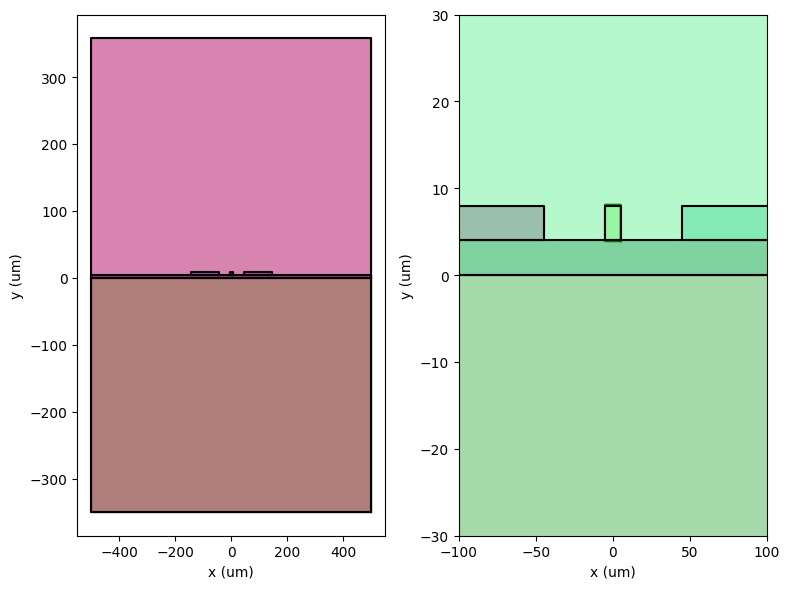

In [2]:
cpw = CPW(
        w_window=1000,
        h_bottom=350,
        h_top=350,
        w_metal_gnd=100,
        w_metal_sig=10,
        metal_sep=40,
        h_bcbp=0,
        h_box=4,
        h_metal=4
    )

fig = plt.figure(figsize=(8,6))
gs = fig.add_gridspec(1,2)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

for ax in [ax1, ax2]:
    cpw.device.plot_polygons(
        color_polygon="black",
        color_line="green",
        color_junctions="blue",
        fill_polygons=True,
        fig=fig,
        ax=ax,
    )

ax2.set_xlim(-100,100)
ax2.set_ylim(-30,30)

ax1.set_xlabel('x (um)')
ax1.set_ylabel('y (um)')
ax2.set_xlabel('x (um)')
ax2.set_ylabel('y (um)')

plt.tight_layout()
plt.show()

Now we initialize the simulator:

Number of elements 9276


(-30.0, 30.0)

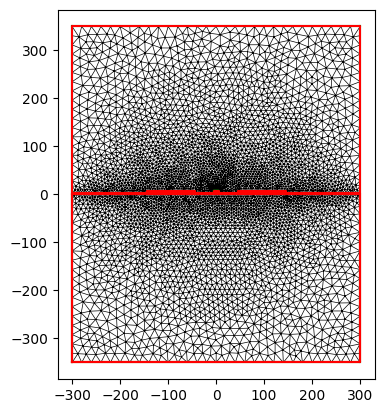

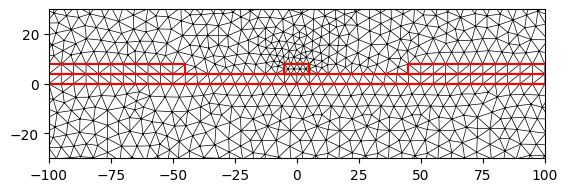

In [3]:
rf_sim = RFSimulatorFEMWELL(cpw.device, simulation_window=shapely.box(-300, -350, 300, 350))
rf_sim.make_mesh(
	gmsh_algorithm=1
)

print('Number of elements', rf_sim.mesh.nelements)
fig, ax = rf_sim.plot_mesh()

fig2, ax2 = rf_sim.plot_mesh()

ax2.set_xlim(-100,100)
ax2.set_ylim(-30,30)

Now we can inspect the permitivity to see if it is properly distributed:

C:\Users\20230622\OneDrive - TU Eindhoven\PhD\Python packages\photonmod\src\imodulator\RFSimulator.py:506: RuntimeWarning: divide by zero encountered in log10
  data_to_plot_im = np.log10(-data_to_plot_im)
c:\Users\20230622\AppData\Local\anaconda3\envs\imodulator_venv\lib\site-packages\skfem\assembly\basis\cell_basis.py:152: RuntimeWarning: invalid value encountered in multiply
  w += y[self.element_dofs[j]][:, None] * basis[0]


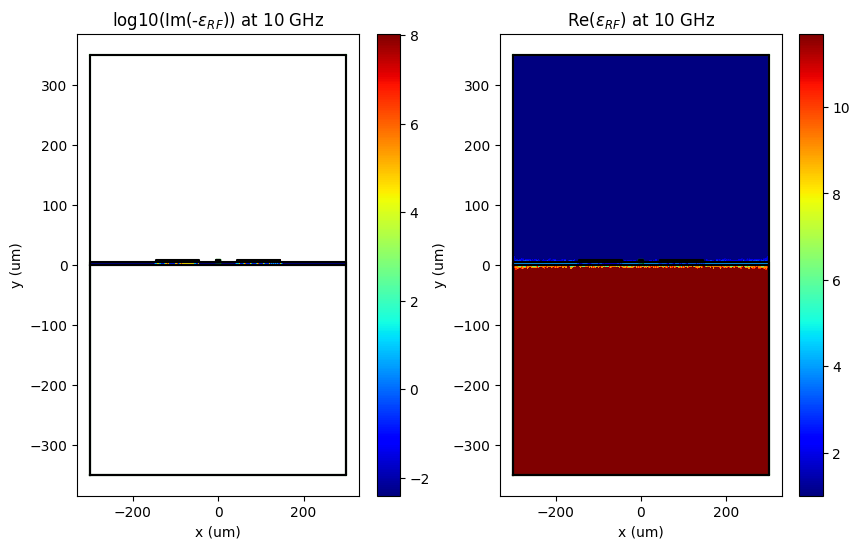

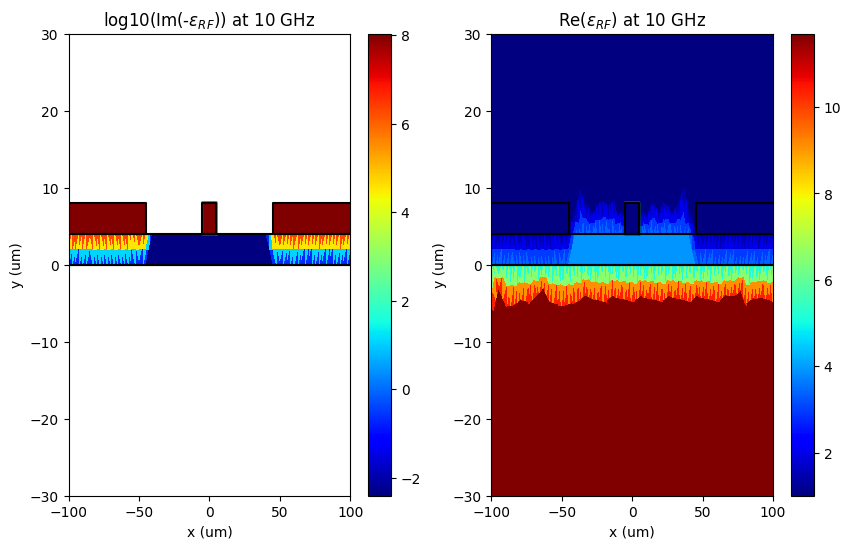

In [4]:
_ = rf_sim.plot_eps_rf(
    frequency=10, #GHz
    log_scale_re=False,
    log_scale_im=True
)

fig, ax1, ax2 = rf_sim.plot_eps_rf(
    frequency=10, #GHz
    log_scale_re=False,
    log_scale_im=True
)

for ax in [ax1, ax2]:
    ax.set_xlim(-100,100)
    ax.set_ylim(-30,30)

We can now compute the modes:

In [5]:
rf_sim.compute_modes(
            frequency = 12,
            metallic_boundaries = ['left', 'bottom','top'],
            n_guess = 2,
            num_modes = 3,
            order = 1,
            return_modes = True,
            use_charge_transport_data=False
)

for i in range(len(rf_sim.modes)):
    print(f'Effective index - mode {i}: {rf_sim.modes[i].n_eff.real:.4f}')
    print(f'loss - mode {i}: {rf_sim.modes[i].calculate_propagation_loss(1e4):.2f} dB/cm')
    print('#------------------------------------------#')

Effective index - mode 0: 1.9740
loss - mode 0: 1.07 dB/cm
#------------------------------------------#
Effective index - mode 1: 2.3693
loss - mode 1: 0.59 dB/cm
#------------------------------------------#
Effective index - mode 2: 2.4850
loss - mode 2: 0.24 dB/cm
#------------------------------------------#


To plot the modes, we have made a custom function that allows you to have a nice streamplot. The downside is that currently it is rather inneficient, so if you have a large amount of elements in your mesh, then, depending on your Nx and Ny values, it can become quite slow.

c:\Users\20230622\AppData\Local\anaconda3\envs\imodulator_venv\lib\site-packages\skfem\assembly\form\linear_form.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  data[ixs] = self._kernel(vbasis.basis[i], w, dx)


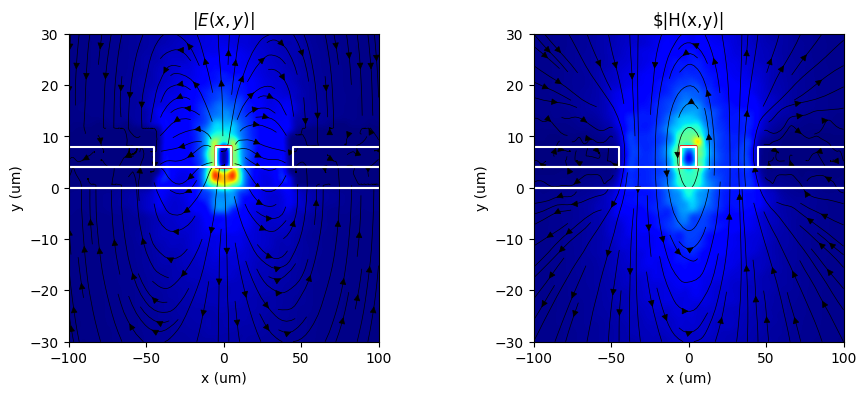

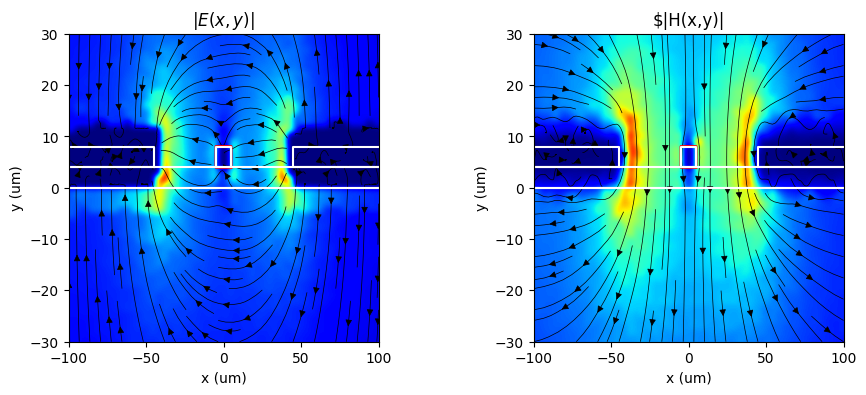

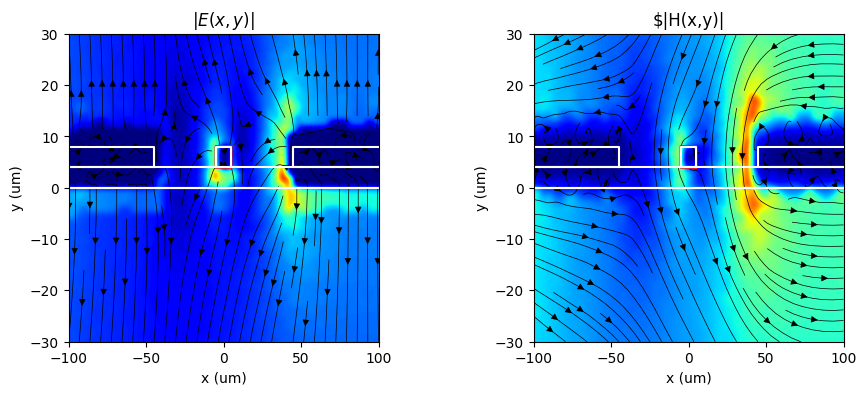

In [6]:
for mode_idx in range(len(rf_sim.modes)):
	rf_sim.plot_mode(
        rf_sim.modes[mode_idx],
        Nx=50,
        Ny=50,
        xmin = -100,
        xmax=100,
        ymin=-30,
        ymax=30
    )

If it happens that the `rf_sim.plot_modes()` function does not work for you for some reason, the modes are still from `FEMWELL` so you can just plot them like this:

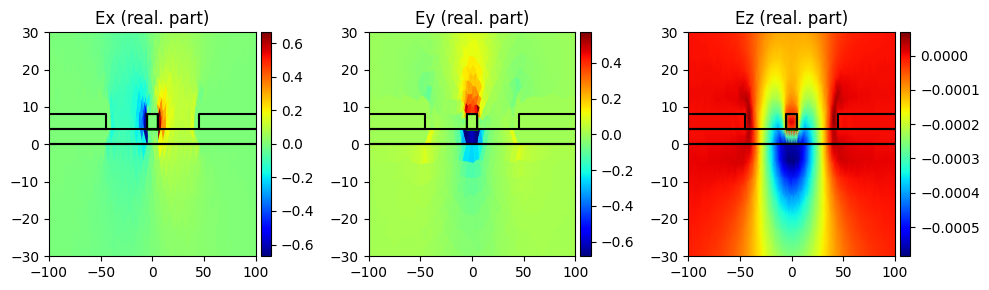

In [7]:
figsize = (10,3)
color_polygons = 'black'

mode = rf_sim.modes[0]

fig = plt.figure(figsize = figsize)
gs = fig.add_gridspec(1,3)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

rf_sim.plot_polygons(fig = fig, ax = ax1, color_polygon=color_polygons)
rf_sim.plot_polygons(fig = fig, ax = ax2, color_polygon=color_polygons)
rf_sim.plot_polygons(fig = fig, ax = ax3, color_polygon=color_polygons)


mode.plot_component('E', 'x', colorbar = True, ax = ax1)
mode.plot_component('E', 'y', colorbar = True, ax = ax2)
mode.plot_component('E', 'z', colorbar = True, ax = ax3)

for ax in [ax1, ax2, ax3]:
    ax.set_xlim(-100,100)
    ax.set_ylim(-30,30)

fig.tight_layout()

Now we are interested in the RF characteristics and to have this system as a transmission line. At this stage it is important you identify the mode you are interested in and what model you want to do. As an example, we will take the even mode of the CPW line, mode index 0 in this case. In this mode, we can clearly see from the magnetic field that we expect a longitudinal current, $i$ to be flowing in one direction in th esignal track, and a current $i/2$ flowing in the opposite direction in the ground tracks. Knowing this, and since our modes are mostly TEM modes, it suffices to calculate this current and to consider $Z=P/i^2$ where $P$ is the power of the mode. Since in `FEMWELL` they are normalized to 1, then we can retrieve the characteristic impedance of our line. Finally, having the propagation constant and the characteristic impedance, we can retrieve the S parameters analytically assuming a linear and reciprocal system.

In [8]:
mode = rf_sim.modes[0]

## Characteristic impedance calculation
print('Effective index:', mode.n_eff)
print('Propagation loss (dB/cm):', mode.calculate_propagation_loss(1e4))

## Characteristic impedance
p0, currents, _= rf_sim.get_currents(mode)
current = currents['sig_metal']
Z0 = p0/(np.abs(current)**2)

print(f'Power: {p0:.3f}')
print(f'Current: {current:.3f}')
print(f'Characteristic impedance: {Z0:.3f}')

## S-parameters calculation
device_length = 1e3 #um
s11, s12 = rf_sim.get_S(
	gamma = mode.k,
	Z=Z0,
	ZL = 50,
	ZS = 50,
	L = device_length
)
print(f'S11: {20*np.log10(np.abs(s11)):.2f} dB')
print(f'S12: {20*np.log10(np.abs(s12)):.2f} dB')

Effective index: (1.9740093329040251-0.0492395139419934j)
Propagation loss (dB/cm): 1.074899655953943
Power: 1.000-0.013j
Current: 0.046+0.029j
Characteristic impedance: 335.845-4.403j
S11: -1.64 dB
S12: -5.52 dB


We can now go a step further and retrieve RLGC parameters based on the work from :cite:t:`marks_general_1992`:

In [9]:
R,L,G,C = rf_sim.get_RLGC(
	mode = mode,
	i0 = current,
	v0 = current*Z0
)

print(f'R: {R:.6f}')
print(f'L: {L:.6f}')
print(f'G: {G:.6f}')
print(f'C: {C:.6f}')

omega = 2*np.pi* 12*rf_sim.reg.GHz

print('Characteristic impedance from RLGC:', np.sqrt((R+1j*omega*L)/(G+1j*omega*C)).to(rf_sim.reg.ohm))

R: 8.746429 milliohm / micrometer
L: 2.222154 picohenry / micrometer
G: 701204.350566 femtosiemens / micrometer
C: 0.020811 femtofarad / micrometer
Characteristic impedance from RLGC: (326.8796207594436-8.453159081234771j) ohm


## Mesh refinement

We can now perform some mesh refinement to get better results.



In [10]:
errors = []
neff = []
loss = []
nelements = []
z0 = []

rf_sim.make_mesh()
for i in range(30):
    print(f'--- Refinement iteration {i} ---')
    
    rf_sim.compute_modes(
            frequency = 12,
            metallic_boundaries = ['left', 'bottom','top'],
            n_guess = 2,
            num_modes = 2,
            order = 1,
            return_modes = True,
            use_charge_transport_data=False
    )

    loss_tmp = []
    for mode in rf_sim.modes:
        loss_tmp.append(mode.calculate_propagation_loss(1e4))

    idx_mode = np.argmin(np.abs(loss_tmp))*0+0
    
    

    ######### Calculate characteristic impedance #########
    p0, i0_all, _ = rf_sim.get_currents(mode = rf_sim.modes[idx_mode])

    I0 = i0_all['sig_metal']
    p0 = p0 

    Z0 = p0/np.abs(I0)**2
    z0.append(Z0)
    ######################################################

    nelements.append(rf_sim.mesh.nelements)
    neff.append(rf_sim.modes[idx_mode].n_eff.real)
    loss.append(rf_sim.modes[idx_mode].calculate_propagation_loss(1e4))

    rf_sim.refine_mesh(mode_for_refinement=rf_sim.modes[idx_mode])

    print(f'Nelements: {rf_sim.mesh.nelements} | neff: {neff[-1]:.6f} | loss: {loss[-1]:.2f} dB/cm | Z0: {z0[-1]:.2f} Ohm')


# plt.show()

--- Refinement iteration 0 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 11410 | neff: 1.957325 | loss: 1.03 dB/cm | Z0: 394.57-6.25j Ohm
--- Refinement iteration 1 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 11528 | neff: 1.948223 | loss: 1.00 dB/cm | Z0: 367.70-6.15j Ohm
--- Refinement iteration 2 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 11590 | neff: 1.942761 | loss: 1.00 dB/cm | Z0: 300.68-5.12j Ohm
--- Refinement iteration 3 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 12028 | neff: 1.945525 | loss: 0.99 dB/cm | Z0: 249.03-4.34j Ohm
--- Refinement iteration 4 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 12160 | neff: 1.947599 | loss: 0.99 dB/cm | Z0: 152.37-2.73j Ohm
--- Refinement iteration 5 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 12574 | neff: 1.949246 | loss: 0.97 dB/cm | Z0: 133.87-2.45j Ohm
--- Refinement iteration 6 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 12940 | neff: 1.949812 | loss: 0.98 dB/cm | Z0: 125.59-2.34j Ohm
--- Refinement iteration 7 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 13102 | neff: 1.948866 | loss: 0.98 dB/cm | Z0: 115.93-2.19j Ohm
--- Refinement iteration 8 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 13508 | neff: 1.947253 | loss: 0.96 dB/cm | Z0: 115.72-2.17j Ohm
--- Refinement iteration 9 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 13564 | neff: 1.952095 | loss: 0.86 dB/cm | Z0: 115.85-2.00j Ohm
--- Refinement iteration 10 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 14260 | neff: 1.952154 | loss: 0.86 dB/cm | Z0: 115.78-2.01j Ohm
--- Refinement iteration 11 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 15068 | neff: 1.955530 | loss: 0.83 dB/cm | Z0: 115.32-1.96j Ohm
--- Refinement iteration 12 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 15248 | neff: 1.953219 | loss: 0.80 dB/cm | Z0: 110.97-1.87j Ohm
--- Refinement iteration 13 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 16526 | neff: 1.953944 | loss: 0.79 dB/cm | Z0: 109.71-1.83j Ohm
--- Refinement iteration 14 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 16704 | neff: 1.955634 | loss: 0.78 dB/cm | Z0: 103.60-1.74j Ohm
--- Refinement iteration 15 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 17838 | neff: 1.955457 | loss: 0.78 dB/cm | Z0: 103.11-1.73j Ohm
--- Refinement iteration 16 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 18272 | neff: 1.953668 | loss: 0.77 dB/cm | Z0: 102.23-1.72j Ohm
--- Refinement iteration 17 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 18514 | neff: 1.952145 | loss: 0.77 dB/cm | Z0: 102.01-1.71j Ohm
--- Refinement iteration 18 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 20432 | neff: 1.951979 | loss: 0.77 dB/cm | Z0: 101.68-1.70j Ohm
--- Refinement iteration 19 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 20550 | neff: 1.950636 | loss: 0.76 dB/cm | Z0: 100.64-1.69j Ohm
--- Refinement iteration 20 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 23220 | neff: 1.950675 | loss: 0.76 dB/cm | Z0: 100.64-1.69j Ohm
--- Refinement iteration 21 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 23958 | neff: 1.949877 | loss: 0.76 dB/cm | Z0: 99.19-1.66j Ohm
--- Refinement iteration 22 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 24100 | neff: 1.949328 | loss: 0.75 dB/cm | Z0: 99.12-1.66j Ohm
--- Refinement iteration 23 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 26338 | neff: 1.949090 | loss: 0.75 dB/cm | Z0: 99.12-1.66j Ohm
--- Refinement iteration 24 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 26362 | neff: 1.949448 | loss: 0.75 dB/cm | Z0: 98.96-1.66j Ohm
--- Refinement iteration 25 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 27770 | neff: 1.949443 | loss: 0.75 dB/cm | Z0: 98.96-1.66j Ohm
--- Refinement iteration 26 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 29828 | neff: 1.949820 | loss: 0.75 dB/cm | Z0: 98.98-1.65j Ohm
--- Refinement iteration 27 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 30964 | neff: 1.948584 | loss: 0.74 dB/cm | Z0: 99.13-1.65j Ohm
--- Refinement iteration 28 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 35016 | neff: 1.947797 | loss: 0.74 dB/cm | Z0: 99.06-1.65j Ohm
--- Refinement iteration 29 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 35030 | neff: 1.947994 | loss: 0.74 dB/cm | Z0: 98.57-1.64j Ohm


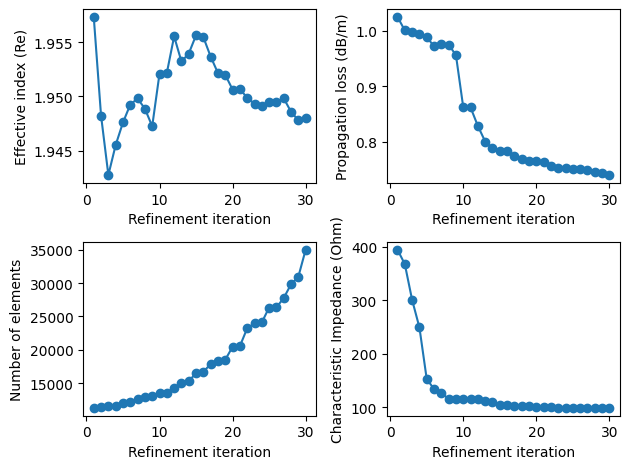

In [11]:
fig = plt.figure()
gs = fig.add_gridspec(2, 2)

n_iterations = np.arange(len(nelements))+1

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

ax1.plot(n_iterations, neff, marker='o')
ax2.plot(n_iterations, loss, marker='o')
ax3.plot(n_iterations, nelements, marker='o')
ax4.plot(n_iterations, np.abs(z0), marker='o')

ax1.set_xlabel('Refinement iteration')
ax2.set_xlabel('Refinement iteration')
ax3.set_xlabel('Refinement iteration')
ax4.set_xlabel('Refinement iteration')

ax1.set_ylabel('Effective index (Re)')
ax2.set_ylabel('Propagation loss (dB/m)')
ax3.set_ylabel('Number of elements')
ax4.set_ylabel('Characteristic Impedance (Ohm)')

plt.tight_layout()
plt.show()

There is a very important remark on the mesh refinement of the RF Simulator. As it stands, the mesh refinement is performed by `skfem` and upon refinement, it does not preserve the named boundaries. This means that we have no way of retrieving the named boundaries, including the lines with which we aim to do line integrals. Therefore, we have made a custom function that find these named lines for us. The downside is that this is very specific to the type of mesh we are using (triangular linear) and the algorithm that we use works by finding the nearest neighbours of the old mesh points in the new mesh. For this reason, we advise that after mesh refinement you check that the line integral domain has been fully preserved. You can inspect it as follows (its far easier if you use the widget backend for matplotlib zoom in into the figure):

(-30.0, 30.0)

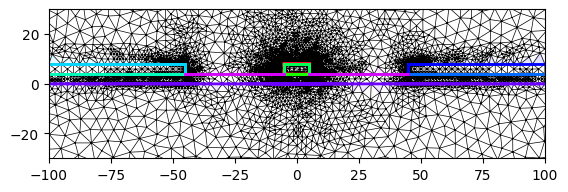

In [12]:
ax = rf_sim.mesh.draw(boundaries=True)

ax.set_axis_on()
ax.set_xlim(-100,100)
ax.set_ylim(-30,30)

In [13]:
R,L,G,C = rf_sim.get_RLGC(
	mode = rf_sim.modes[0],
	i0 = current,
	v0 = current*Z0
)

print(f'R: {R:.6f}')
print(f'L: {L:.6f}')
print(f'G: {G:.6f}')
print(f'C: {C:.6f}')

omega = 2*np.pi* 12*rf_sim.reg.GHz

print(f'Characteristic impedance from RLGC: {np.sqrt((R+1j*omega*L)/(G+1j*omega*C)).to(rf_sim.reg.ohm):.2f}')
print(f'Characteristic impedance from mode calculation: {z0[-1]:.2f} Ohm')


R: 5.678070 milliohm / micrometer
L: 2.177310 picohenry / micrometer
G: 7009254.733098 femtosiemens / micrometer
C: 0.225548 femtofarad / micrometer
Characteristic impedance from RLGC: 98.27-1.68j ohm
Characteristic impedance from mode calculation: 98.57-1.64j Ohm


## Using a symmetry plane

To speed up our computation we can make use of symmetry.

Number of elements 3084


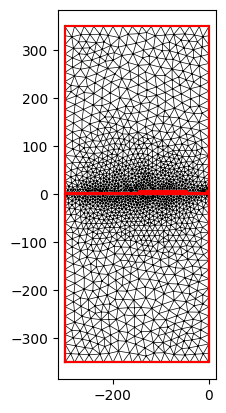

In [14]:
rf_sim = RFSimulatorFEMWELL(cpw.device, simulation_window=shapely.box(-300, -350, 0, 350))
rf_sim.make_mesh(
	gmsh_algorithm=1
)

print('Number of elements', rf_sim.mesh.nelements)
fig, ax = rf_sim.plot_mesh()

In [15]:
rf_sim.compute_modes(
            frequency = 12,
            metallic_boundaries = ['left', 'bottom','top'],
            n_guess = 2,
            num_modes = 2,
            order = 1,
            return_modes = True,
            use_charge_transport_data=False
)

for i in range(len(rf_sim.modes)):
    print(f'Effective index - mode {i}: {rf_sim.modes[i].n_eff.real:.4f}')
    print(f'loss - mode {i}: {rf_sim.modes[i].calculate_propagation_loss(1e4):.2f} dB/cm')
    print('#------------------------------------------#')

Effective index - mode 0: 1.9511
loss - mode 0: 1.03 dB/cm
#------------------------------------------#
Effective index - mode 1: 2.4477
loss - mode 1: 0.28 dB/cm
#------------------------------------------#


c:\Users\20230622\AppData\Local\anaconda3\envs\imodulator_venv\lib\site-packages\skfem\assembly\form\linear_form.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  data[ixs] = self._kernel(vbasis.basis[i], w, dx)


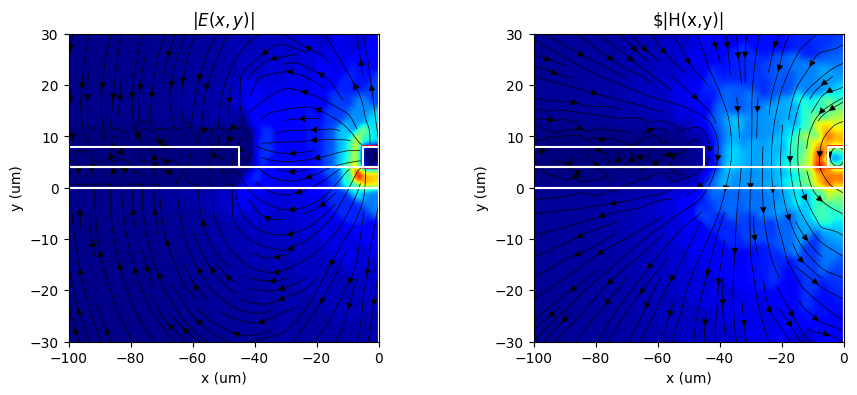

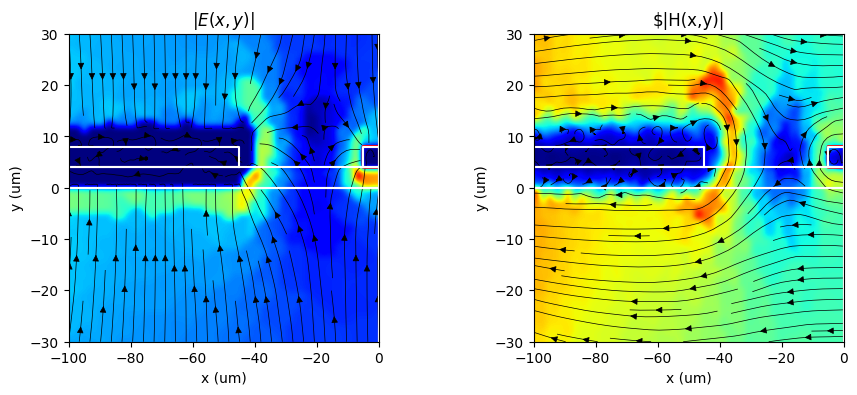

In [16]:
for mode_idx in range(len(rf_sim.modes)):
	rf_sim.plot_mode(
        rf_sim.modes[mode_idx],
        Nx=50,
        Ny=50,
        xmin = -100,
        xmax=0,
        ymin=-30,
        ymax=30
    )

Now, however, it becomes slightly more tricky for tthe impedance calculation. This is where you must be aware of what you are calculating. We have used a symmetry plane by simply cutting all of our polygons by the `simulation_window` box. This also includes the line for the line integral. This means that the value of the current that we get from the `RFSimulatorFEMWELL` will only give you half the real current. Coincidently, the value of the power of the field is also halved because the field we are actually interested is twice the value of the one we calculated. Therefore we must correct the values of the current and power to get the same values as before:

In [17]:
mode = rf_sim.modes[0]

## Characteristic impedance calculation
print('Effective index:', mode.n_eff)
print('Propagation loss (dB/cm):', mode.calculate_propagation_loss(1e4))

## Characteristic impedance
p0, currents, _= rf_sim.get_currents(mode)
current = currents['sig_metal']

############ CORRECTION FOR SYMMETRY PLANE ###########
p0 = p0*2
current = current*2
######################################################

Z0 = p0/(np.abs(current)**2)

print(f'Power: {p0:.3f}')
print(f'Current: {current:.3f}')
print(f'Characteristic impedance: {Z0:.3f}')

## S-parameters calculation
device_length = 1e3 #um
s11, s12 = rf_sim.get_S(
	gamma = mode.k,
	Z=Z0,
	ZL = 50,
	ZS = 50,
	L = device_length
)
print(f'S11: {20*np.log10(np.abs(s11)):.2f} dB')
print(f'S12: {20*np.log10(np.abs(s12)):.2f} dB')

Effective index: (1.951076416789967-0.04730922364306794j)
Propagation loss (dB/cm): 1.032761376915476
Power: 2.000-0.023j
Current: 0.063+0.038j
Characteristic impedance: 370.569-4.326j
S11: -1.41 dB
S12: -6.09 dB


We can now do the mesh refinement to get nicer results:

In [18]:
errors = []
neff = []
loss = []
nelements = []
z0 = []

rf_sim.make_mesh()
for i in range(30):
    print(f'--- Refinement iteration {i} ---')
    
    rf_sim.compute_modes(
            frequency = 12,
            metallic_boundaries = ['left', 'bottom','top'],
            n_guess = 2,
            num_modes = 2,
            order = 1,
            return_modes = True,
            use_charge_transport_data=False
    )

    loss_tmp = []
    for mode in rf_sim.modes:
        loss_tmp.append(mode.calculate_propagation_loss(1e4))

    idx_mode = np.argmin(np.abs(loss_tmp))*0+0
    
    

    ######### Calculate characteristic impedance #########
    p0, i0_all, _ = rf_sim.get_currents(mode = rf_sim.modes[idx_mode])

    I0 = 2*i0_all['sig_metal']
    p0 = 2*p0 #This correction is needed as the power of the actual field we are interested in is twice of the one calculated by the simulator

    Z0 = p0/np.abs(I0)**2
    z0.append(Z0)
    ######################################################

    nelements.append(rf_sim.mesh.nelements)
    neff.append(rf_sim.modes[idx_mode].n_eff.real)
    loss.append(rf_sim.modes[idx_mode].calculate_propagation_loss(1e4))

    rf_sim.refine_mesh(mode_for_refinement=rf_sim.modes[idx_mode])

    print(f'Nelements: {rf_sim.mesh.nelements} | neff: {neff[-1]:.6f} | loss: {loss[-1]:.2f} dB/cm | Z0: {z0[-1]:.2f} Ohm')


# plt.show()

--- Refinement iteration 0 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 3396 | neff: 1.959387 | loss: 1.12 dB/cm | Z0: 244.12-4.10j Ohm
--- Refinement iteration 1 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 3471 | neff: 1.941606 | loss: 1.09 dB/cm | Z0: 242.48-4.18j Ohm
--- Refinement iteration 2 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 3549 | neff: 1.941736 | loss: 1.09 dB/cm | Z0: 209.18-3.81j Ohm
--- Refinement iteration 3 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 3563 | neff: 1.935515 | loss: 1.09 dB/cm | Z0: 179.48-3.38j Ohm
--- Refinement iteration 4 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 3621 | neff: 1.932091 | loss: 1.09 dB/cm | Z0: 178.93-3.37j Ohm
--- Refinement iteration 5 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 3801 | neff: 1.929431 | loss: 1.06 dB/cm | Z0: 157.95-3.00j Ohm
--- Refinement iteration 6 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 4058 | neff: 1.934126 | loss: 1.06 dB/cm | Z0: 142.62-2.76j Ohm
--- Refinement iteration 7 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 4254 | neff: 1.949172 | loss: 0.99 dB/cm | Z0: 126.56-2.37j Ohm
--- Refinement iteration 8 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 4300 | neff: 1.947226 | loss: 0.93 dB/cm | Z0: 115.01-2.08j Ohm
--- Refinement iteration 9 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 4763 | neff: 1.948255 | loss: 0.92 dB/cm | Z0: 112.35-2.02j Ohm
--- Refinement iteration 10 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 5099 | neff: 1.953556 | loss: 0.85 dB/cm | Z0: 109.49-1.87j Ohm
--- Refinement iteration 11 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 5757 | neff: 1.953105 | loss: 0.85 dB/cm | Z0: 108.43-1.89j Ohm
--- Refinement iteration 12 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 6092 | neff: 1.949197 | loss: 0.81 dB/cm | Z0: 104.07-1.79j Ohm
--- Refinement iteration 13 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 7154 | neff: 1.949570 | loss: 0.80 dB/cm | Z0: 101.49-1.73j Ohm
--- Refinement iteration 14 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 7222 | neff: 1.952152 | loss: 0.79 dB/cm | Z0: 100.23-1.72j Ohm
--- Refinement iteration 15 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 7286 | neff: 1.951713 | loss: 0.79 dB/cm | Z0: 100.16-1.72j Ohm
--- Refinement iteration 16 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 7526 | neff: 1.951660 | loss: 0.79 dB/cm | Z0: 100.12-1.72j Ohm
--- Refinement iteration 17 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 8629 | neff: 1.950829 | loss: 0.79 dB/cm | Z0: 100.14-1.72j Ohm
--- Refinement iteration 18 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 8653 | neff: 1.952366 | loss: 0.78 dB/cm | Z0: 98.97-1.68j Ohm
--- Refinement iteration 19 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 9275 | neff: 1.952440 | loss: 0.77 dB/cm | Z0: 98.98-1.68j Ohm
--- Refinement iteration 20 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 9311 | neff: 1.951490 | loss: 0.76 dB/cm | Z0: 98.96-1.66j Ohm
--- Refinement iteration 21 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 11070 | neff: 1.951359 | loss: 0.76 dB/cm | Z0: 98.98-1.66j Ohm
--- Refinement iteration 22 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 11432 | neff: 1.950536 | loss: 0.75 dB/cm | Z0: 98.72-1.65j Ohm
--- Refinement iteration 23 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 11483 | neff: 1.950413 | loss: 0.75 dB/cm | Z0: 98.74-1.65j Ohm
--- Refinement iteration 24 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 11639 | neff: 1.950290 | loss: 0.75 dB/cm | Z0: 98.72-1.65j Ohm
--- Refinement iteration 25 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 14873 | neff: 1.950133 | loss: 0.75 dB/cm | Z0: 98.71-1.65j Ohm
--- Refinement iteration 26 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 15201 | neff: 1.947353 | loss: 0.74 dB/cm | Z0: 98.31-1.64j Ohm
--- Refinement iteration 27 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 15947 | neff: 1.946468 | loss: 0.74 dB/cm | Z0: 98.43-1.64j Ohm
--- Refinement iteration 28 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 16279 | neff: 1.945947 | loss: 0.74 dB/cm | Z0: 98.56-1.64j Ohm
--- Refinement iteration 29 ---


Named boundaries invalidated by a call to Mesh.refined()


Nelements: 20257 | neff: 1.946002 | loss: 0.74 dB/cm | Z0: 98.58-1.64j Ohm


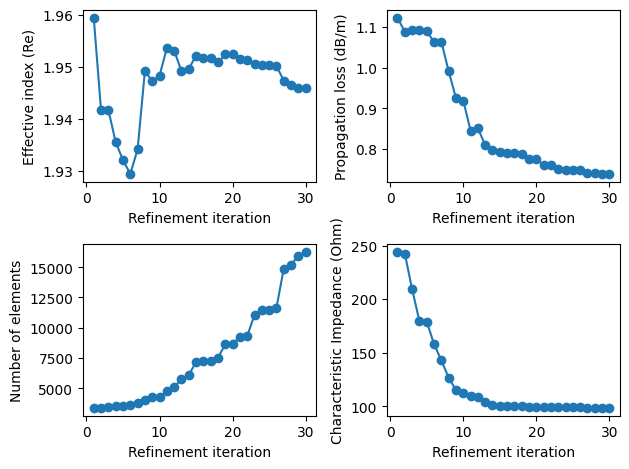

In [19]:
fig = plt.figure()
gs = fig.add_gridspec(2, 2)

n_iterations = np.arange(len(nelements))+1

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

ax1.plot(n_iterations, neff, marker='o')
ax2.plot(n_iterations, loss, marker='o')
ax3.plot(n_iterations, nelements, marker='o')
ax4.plot(n_iterations, np.abs(z0), marker='o')

ax1.set_xlabel('Refinement iteration')
ax2.set_xlabel('Refinement iteration')
ax3.set_xlabel('Refinement iteration')
ax4.set_xlabel('Refinement iteration')

ax1.set_ylabel('Effective index (Re)')
ax2.set_ylabel('Propagation loss (dB/m)')
ax3.set_ylabel('Number of elements')
ax4.set_ylabel('Characteristic Impedance (Ohm)')

plt.tight_layout()
plt.show()

## Frequency sweep

In [21]:
freq_values = np.linspace(1,100,30)

n_modes = 2
neff_values = np.zeros((n_modes, freq_values.shape[0]))
loss_values = np.zeros((n_modes, freq_values.shape[0]))
Z0_values = np.zeros((n_modes, freq_values.shape[0]), dtype=complex)
s11_values = np.zeros((n_modes, freq_values.shape[0]), dtype=complex)
s12_values = np.zeros((n_modes, freq_values.shape[0]), dtype=complex)

for i, f in enumerate(freq_values):
    print(f'--- Frequency: {f} GHz ---')
    rf_sim.compute_modes(
        frequency = f,
        metallic_boundaries = ['left', 'bottom', 'top'],
        voltage_idx = 0,
        n_guess = 2,
        num_modes = n_modes,
        order = 1,
        return_modes = False,
        use_charge_transport_data=False
    )

    #Let us select the mode that has a positive value for loss
    #The current geometry will only allow for one physical mode. We are purposely calculating two modes, but one of them will be some radiative mode with negative loss (gain).
    for j in range(n_modes):
        loss = rf_sim.modes[j].calculate_propagation_loss(1e4) #dB/cm
        p0, i0_all, _ = rf_sim.get_currents(mode = rf_sim.modes[j])

        p0 = 2*p0 
        I0 = 2*i0_all['sig_metal']

        Z0 = p0/np.abs(I0)**2

        s11, s12 = rf_sim.get_S(
            rf_sim.modes[j].k,
            Z = Z0 ,
            ZL=50,
            ZS = 50,
            L = 1e3 #um
        )
        

        neff_values[j, i] = rf_sim.modes[j].n_eff.real
        loss_values[j, i] = rf_sim.modes[j].calculate_propagation_loss(1e4) #dB/cm
        Z0_values[j, i] = Z0
        s11_values[j, i] = s11
        s12_values[j, i] = s12

--- Frequency: 1.0 GHz ---
--- Frequency: 4.413793103448276 GHz ---
--- Frequency: 7.827586206896552 GHz ---
--- Frequency: 11.241379310344827 GHz ---
--- Frequency: 14.655172413793103 GHz ---
--- Frequency: 18.06896551724138 GHz ---
--- Frequency: 21.482758620689655 GHz ---
--- Frequency: 24.89655172413793 GHz ---
--- Frequency: 28.310344827586206 GHz ---
--- Frequency: 31.724137931034484 GHz ---
--- Frequency: 35.13793103448276 GHz ---
--- Frequency: 38.55172413793103 GHz ---
--- Frequency: 41.96551724137931 GHz ---
--- Frequency: 45.37931034482759 GHz ---
--- Frequency: 48.79310344827586 GHz ---
--- Frequency: 52.206896551724135 GHz ---
--- Frequency: 55.62068965517241 GHz ---
--- Frequency: 59.03448275862069 GHz ---
--- Frequency: 62.44827586206897 GHz ---
--- Frequency: 65.86206896551724 GHz ---
--- Frequency: 69.27586206896552 GHz ---
--- Frequency: 72.6896551724138 GHz ---
--- Frequency: 76.10344827586206 GHz ---
--- Frequency: 79.51724137931035 GHz ---
--- Frequency: 82.9310344

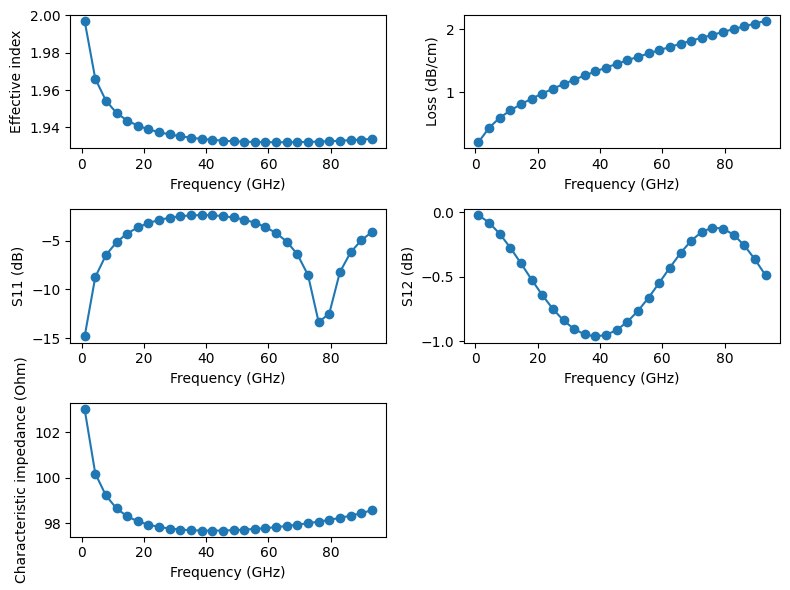

In [25]:
fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(3, 2)

ax_neff = fig.add_subplot(gs[0, 0])
ax_loss = fig.add_subplot(gs[0, 1])
ax_Z0 = fig.add_subplot(gs[2, 0])
ax_s11 = fig.add_subplot(gs[1, 0])
ax_s12 = fig.add_subplot(gs[1, 1])

a = -2
for i in [0]:
    ax_neff.plot(freq_values[:a], neff_values[i, :a], label=f'Mode {i}', marker='o')

    ax_loss.plot(freq_values[:a], loss_values[i, :a], label=f'Mode {i}', marker='o')

    # ax_Z0.plot(freq_values[:a], Z0_values[i, :a].real, label=f'Mode {i} (Re)', marker='o')
    # ax_Z0.plot(freq_values[:a], Z0_values[i, :a].imag, label=f'Mode {i} (Im)', marker='o')
    ax_Z0.plot(freq_values[:a], np.abs(Z0_values[i, :a]), label=f'Mode {i} (Abs)', marker='o')

    ax_s11.plot(freq_values[:a], 10 * np.log10(np.abs(s11_values[i, :a])), label=f'Mode {i} (Re)', marker='o')

    ax_s12.plot(freq_values[:a], 10 * np.log10(np.abs(s12_values[i, :a])), label=f'Mode {i} (Re)', marker='o')

# ax_neff.set_ylim(2,5)
ax_neff.set_xlabel('Frequency (GHz)')
ax_neff.set_ylabel('Effective index')

ax_loss.set_xlabel('Frequency (GHz)')
ax_loss.set_ylabel('Loss (dB/cm)')

ax_Z0.set_xlabel('Frequency (GHz)')
ax_Z0.set_ylabel('Characteristic impedance (Ohm)')

ax_s11.set_xlabel('Frequency (GHz)')
ax_s11.set_ylabel('S11 (dB)')

ax_s12.set_xlabel('Frequency (GHz)')
ax_s12.set_ylabel('S12 (dB)')

fig.tight_layout()

plt.show()